In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from scipy.special import expit
from scipy import interpolate
from scipy import integrate
from collections import Counter
from matplotlib.colors import ListedColormap

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('default')

import ABROCA

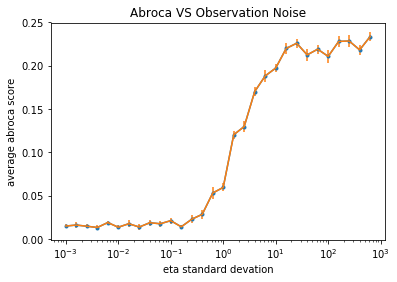

In [2]:
# observation noise vs. ABROCA plot example
avg_abrocas, eta_sds, errors = ABROCA.ABROCAvs_plot('obs_noise', [10**i for i in np.arange(-3,3,0.2)], s=13, n=[5000,5000], r=10)
plt.xscale('log')
plt.yscale('linear')
plt.plot(eta_sds, avg_abrocas, marker='.')
plt.errorbar(eta_sds, avg_abrocas, yerr=errors)
plt.xlabel('eta standard devation')
plt.ylabel('average abroca score')
plt.title('Abroca VS Observation Noise')
plt.show()

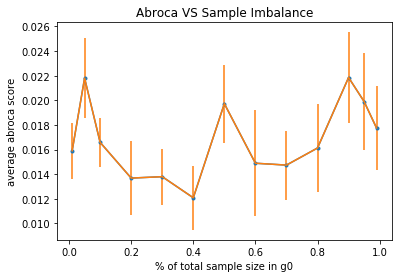

In [10]:
# sample imbalance vs. ABROCA plot example
a = [.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]

avg_abrocas, g0_percent, errors = ABROCA.ABROCAvs_plot('sample_size', a, s=13, n=[5000,5000], r=10)
plt.xscale('linear')
plt.yscale('linear')
plt.plot(g0_percent, avg_abrocas, marker='.')
plt.errorbar(g0_percent, avg_abrocas, yerr=errors)
plt.xlabel('% of total sample size in g0')
plt.ylabel('average abroca score')
plt.title('Abroca VS Sample Imbalance')
plt.show()

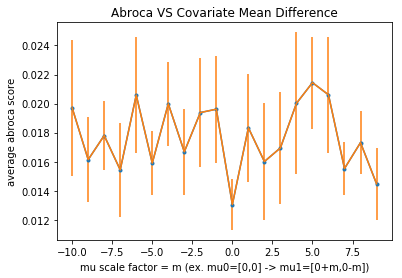

In [11]:
# covariate mean difference vs. ABROCA plot example
avg_abrocas, mu_scale, errors = ABROCA.ABROCAvs_plot('cov_means', np.arange(-10,10,1), s=13, n=[5000,5000])
plt.xscale('linear')
plt.yscale('linear')
plt.plot(mu_scale, avg_abrocas, marker='.')
plt.errorbar(mu_scale, avg_abrocas, yerr=errors)
plt.xlabel('mu scale factor = m (ex. mu0=[0,0] -> mu1=[0+m,0-m])')
plt.ylabel('average abroca score')
plt.title('Abroca VS Covariate Mean Difference')
plt.show()

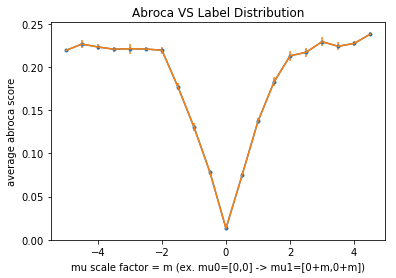

In [2]:
# label distribution vs. ABROCA plot example
avg_abrocas, mu_scale, errors = ABROCA.ABROCAvs_plot('label_dist', np.arange(-5,5,.5), s=13, n=[5000,5000])
plt.xscale('linear')
plt.yscale('linear')
plt.plot(mu_scale, avg_abrocas, marker='.')
plt.errorbar(mu_scale, avg_abrocas, yerr=errors)
plt.xlabel('mu scale factor = m (ex. mu0=[0,0] -> mu1=[0+m,0+m])')
plt.ylabel('average abroca score')
plt.title('Abroca VS Label Distribution')
plt.show()

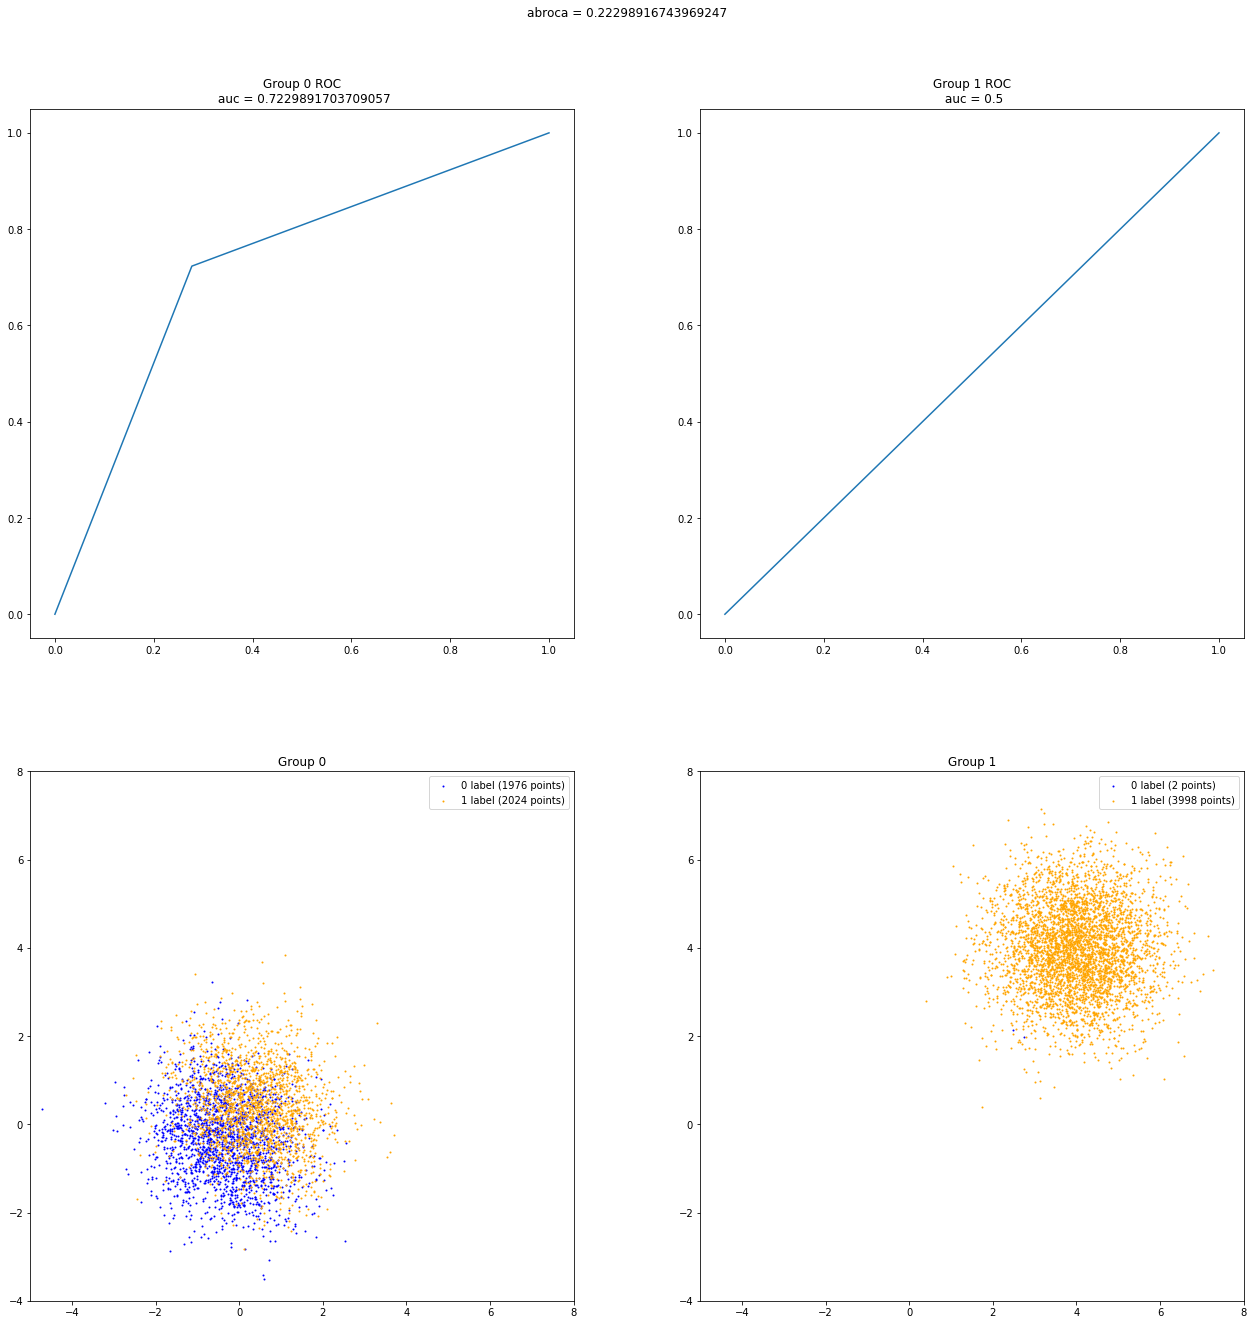

In [4]:
# visualize data
fig, axs = plt.subplots(2, 2, figsize=(20,20))

np.random.seed(13)
n= [5000, 5000]
X, y = ABROCA.simulate(subgroup_n=n, mu_scale_factor=4, label_prop=True)

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)

X_train = np.append(X_train_0, X_train_1, axis=0)
y_train = np.append(y_train_0, y_train_1, axis=0)

perm = np.random.permutation(len(y_train))

regressor = LogisticRegressionCV(cv=5, random_state=0)
regressor.fit(X_train[perm], y_train[perm])

y_pred_0 = regressor.predict(X_test_0)
y_pred_1 = regressor.predict(X_test_1)

fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)
g0auc = auc(fpr_0, tpr_0)
g1auc = auc(fpr_1, tpr_1)
abroca = ABROCA.compute_abroca(fpr_0,tpr_0,fpr_1,tpr_1)

axs[0,0].plot(fpr_0, tpr_0)
axs[0,0].set_title(f'Group 0 ROC\n auc = {g0auc}')
axs[0,1].plot(fpr_1, tpr_1)
axs[0,1].set_title(f'Group 1 ROC\n auc = {g1auc}')

plot_x0_0 = [a for a,b in zip(X_train_0[:,0], y_train_0) if b==0]
plot_y0_0 = [a for a,b in zip(X_train_0[:,1], y_train_0) if b==0]
axs[1,0].scatter(plot_x0_0, plot_y0_0, color='blue', s=1, label=f'0 label ({len(plot_x0_0)} points)')
plot_x0_1 = [a for a,b in zip(X_train_0[:,0], y_train_0) if b==1]
plot_y0_1 = [a for a,b in zip(X_train_0[:,1], y_train_0) if b==1]
axs[1,0].scatter(plot_x0_1, plot_y0_1, color='orange', s=1, label=f'1 label ({len(plot_x0_1)} points)')
axs[1,0].legend()
axs[1,0].set_title('Group 0')


plot_x1_0 = [a for a,b in zip(X_train_1[:,0], y_train_1) if b==0]
plot_y1_0 = [a for a,b in zip(X_train_1[:,1], y_train_1) if b==0]
axs[1,1].scatter(plot_x1_0, plot_y1_0, color='blue', s=1, label=f'0 label ({len(plot_x1_0)} points)')
plot_x1_1 = [a for a,b in zip(X_train_1[:,0], y_train_1) if b==1]
plot_y1_1 = [a for a,b in zip(X_train_1[:,1], y_train_1) if b==1]
axs[1,1].scatter(plot_x1_1, plot_y1_1, color='orange', s=1, label=f'1 label ({len(plot_x1_1)} points)')
axs[1,1].legend()
axs[1,1].set_title('Group 1')

xlim = [int(min(plot_x0_0+plot_x0_1+plot_x1_0+plot_x1_1))-1, int(max(plot_x0_0+plot_x0_1+plot_x1_0+plot_x1_1))+1]
ylim = [int(min(plot_y0_0+plot_y0_1+plot_y1_0+plot_y1_1))-1, int(max(plot_y0_0+plot_y0_1+plot_y1_0+plot_y1_1))+1]
axs[1,0].set_xlim(xlim)
axs[1,1].set_xlim(xlim)
axs[1,0].set_ylim(ylim)
axs[1,1].set_ylim(ylim)

fig.suptitle(f'abroca = {abroca}')
fig.tight_layout(pad=10.0)